# Imports & Global Constants

In [ ]:
# 노트북 실행에 필요한 라이브러리를 설치합니다
# 주피터 노트북에 맞춰 세팅 변경
%pip install opencv-python-headless==4.10.0.84
%pip install pandas==2.2.3
%pip install -U scikit-learn==1.5.2
%pip install albumentations==1.4.18
%pip install matplotlib==3.9.2
%pip install openpyxl

  Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.10.0.84-cp37-abi3-win_amd64.whl (38.8 MB)
  Using cached pytz-2024.2-py2.py3-none-any.whl.metadata (22 kB)
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
   ------ --------------------------------- 1.8/11.6 MB 9.1 MB/s eta 0:00:02
   ------------- -------------------------- 3.9/11.6 MB 9.0 MB/s eta 0:00:01
   ------------------ --------------------- 5.2/11.6 MB 8.4 MB/s eta 0:00:01
   -------------------------- ------------- 7.6/11.6 MB 9.0 MB/s eta 0:00:01
   --------------------------------- ------ 9.7/11.6 MB 9.0 MB/s eta 0:00:01
   ------------------------------------- -- 10.7/11.6 MB 8.6 MB/s eta 0:00:01
   ---------------------------------------  11.5/11.6 MB 8.5 MB/s eta 0:00:01
   ---------------------------------------- 11.6/11.6 MB 7.6 MB/s eta 0:00:00
Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)
  Using cached scipy-1

In [3]:
# python native
import os
import json
import random
import datetime
from functools import partial

# external library
import cv2
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
from sklearn.model_selection import GroupKFold
import albumentations as A

# torch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

c:\Users\clear\miniconda3\envs\deep_learning\lib\site-packages\albumentations\__init__.py:13: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.18). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
# 데이터 경로를 입력하세요

IMAGE_ROOT = "../train/DCM"
LABEL_ROOT = "../train/outputs_json"

In [7]:
CLASSES = [
    'finger-1', 'finger-2', 'finger-3', 'finger-4', 'finger-5',
    'finger-6', 'finger-7', 'finger-8', 'finger-9', 'finger-10',
    'finger-11', 'finger-12', 'finger-13', 'finger-14', 'finger-15',
    'finger-16', 'finger-17', 'finger-18', 'finger-19', 'Trapezium',
    'Trapezoid', 'Capitate', 'Hamate', 'Scaphoid', 'Lunate',
    'Triquetrum', 'Pisiform', 'Radius', 'Ulna',
]

# mapping
CLASS2IND = {v: i for i, v in enumerate(CLASSES)}
IND2CLASS = {v: k for k, v in CLASS2IND.items()}

In [8]:
# training setting
BATCH_SIZE = 8
LR = 1e-4
RANDOM_SEED = 21

NUM_EPOCHS = 5
VAL_EVERY = 5

SAVED_DIR = "checkpoints"

if not os.path.exists(SAVED_DIR):                                                           
    os.makedirs(SAVED_DIR)

# Check the Size of the Dataset

`IMAGE_ROOT` 아래에 있는 모든 폴더를 재귀적으로 순회하면서 확장자가 `.png`인 파일들을 찾습니다.

In [9]:
# pngs : png로 되어있는 파일 이름
# jsons : json으로 되어있는 파일 이름

pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}


jsons = {
    os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
    for root, _dirs, files in os.walk(LABEL_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".json"
}



모든 `.png` 파일에 대해 `.json` pair가 존재하는지 체크합니다. 파일명에서 확장자를 제거한 set을 생성하고 두 집합의 차집합의 크기가 0인지 확인합니다.

In [10]:
jsons_fn_prefix = {os.path.splitext(fname)[0] for fname in jsons}
pngs_fn_prefix = {os.path.splitext(fname)[0] for fname in pngs}

assert len(jsons_fn_prefix - pngs_fn_prefix) == 0
assert len(pngs_fn_prefix - jsons_fn_prefix) == 0

모든 `.png` 파일에 대해 label이 존재하는 것을 확인했습니다. 이름 순으로 정렬해서 짝이 맞도록 합니다.

In [11]:
pngs = sorted(pngs)
jsons = sorted(jsons)

# Define Dataset Class

In [12]:
class XRayDataset(Dataset):
    def __init__(self, is_train=True, transforms=None):
        _filenames = np.array(pngs)
        _labelnames = np.array(jsons)
        
        # split train-valid
        # 한 폴더 안에 한 인물의 양손에 대한 `.dcm` 파일이 존재하기 때문에
        # 폴더 이름을 그룹으로 해서 GroupKFold를 수행합니다.
        # 동일 인물의 손이 train, valid에 따로 들어가는 것을 방지합니다.
        groups = [os.path.dirname(fname) for fname in _filenames]
        
        # dummy label
        ys = [0 for fname in _filenames]
        
        # 전체 데이터의 20%를 validation data로 쓰기 위해 `n_splits`를
        # 5으로 설정하여 KFold를 수행합니다.
        gkf = GroupKFold(n_splits=5)
        
        filenames = []
        labelnames = []
        for i, (x, y) in enumerate(gkf.split(_filenames, ys, groups)):
            if is_train:
                # 0번을 validation dataset으로 사용합니다.
                if i == 0:
                    continue
                    
                filenames += list(_filenames[y])
                labelnames += list(_labelnames[y])
            
            else:
                filenames = list(_filenames[y])
                labelnames = list(_labelnames[y])
                
                # skip i > 0
                break
        
        self.filenames = filenames
        self.labelnames = labelnames
        self.is_train = is_train
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        label_name = self.labelnames[item]
        label_path = os.path.join(LABEL_ROOT, label_name)
        
        # (H, W, NC) 모양의 label을 생성합니다.
        label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
        label = np.zeros(label_shape, dtype=np.uint8)
        
        # label 파일을 읽습니다.
        with open(label_path, "r") as f:
            annotations = json.load(f)
        annotations = annotations["annotations"]
        
        # 클래스 별로 처리합니다.
        for ann in annotations:
            c = ann["label"]
            class_ind = CLASS2IND[c]
            points = np.array(ann["points"])
            
            # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
            class_label = np.zeros(image.shape[:2], dtype=np.uint8)
            cv2.fillPoly(class_label, [points], 1)
            label[..., class_ind] = class_label
        
        if self.transforms is not None:
            inputs = {"image": image, "mask": label} if self.is_train else {"image": image}
            result = self.transforms(**inputs)
            
            image = result["image"]
            label = result["mask"] if self.is_train else label

        # to tenser will be done later
        image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
        label = label.transpose(2, 0, 1)
        
        image = torch.from_numpy(image).float()
        label = torch.from_numpy(label).float()
            
        return image, label

In [13]:

tf = A.Resize(512, 512)
train_dataset = XRayDataset(is_train=True, transforms=tf)
valid_dataset = XRayDataset(is_train=False, transforms=tf)
image, label = train_dataset[0]
print(image.shape, label.shape)

torch.Size([3, 512, 512]) torch.Size([29, 512, 512])


# Check Data Sample

In [30]:
# 시각화를 위한 팔레트를 설정합니다.
PALETTE = [
    (220, 20, 60), (119, 11, 32), (0, 0, 142), (0, 0, 230), (106, 0, 228),
    (0, 60, 100), (0, 80, 100), (0, 0, 70), (0, 0, 192), (250, 170, 30),
    (100, 170, 30), (220, 220, 0), (175, 116, 175), (250, 0, 30), (165, 42, 42),
    (255, 77, 255), (0, 226, 252), (182, 182, 255), (0, 82, 0), (120, 166, 157),
    (110, 76, 0), (174, 57, 255), (199, 100, 0), (72, 0, 118), (255, 179, 240),
    (0, 125, 92), (209, 0, 151), (188, 208, 182), (0, 220, 176),
]

# 파란색 계열이 제대로 안 보이기 때문에 색 수정
PALETTE[3] = (255,0,142)
PALETTE[4] = (255,0,230)
PALETTE[7] = (255,230,151)
PALETTE[8] = (132, 185, 192)


# 겹치는 픽셀에 사용할 색 (A 색)
OVERLAP_COLOR = (255, 255, 255)  # 흰색으로 설정 (변경 가능)

# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
# 클래스가 2개 이상인 픽셀을 뽑아주면 좋을 것 같다.
# validation 하는 도중 틀린 것들만 시각화를 따로 해주는 것도 좋을거 같은데...
# 어떻게 해줘야 할까?
# 시각화 함수입니다. 클래스가 2개 이상인 픽셀을 고려하지는 않습니다.
def label2rgb(label):
    image_size = label.shape[1:] + (3, ) # (512,512,3)
    image = np.zeros(image_size, dtype=np.uint8)
    for i, class_label in enumerate(label):
        image[class_label == 1] = PALETTE[i]
    return image

def label2rgb_duplication(label):
    # Tensor일 경우 numpy 배열로 변환
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()

    # 출력 이미지를 생성합니다.
    image_size = label.shape[1:] + (3,)  # (H, W, 3)
    image = np.zeros(image_size, dtype=np.uint8)

    # 중복을 체크하기 위해 중간 결과를 저장할 배열 생성
    overlap_mask = np.zeros(label.shape[1:], dtype=bool)

    # 각 클래스의 픽셀을 채워줍니다.
    for i, class_label in enumerate(label):
        # 현재 클래스의 픽셀을 numpy 배열로 변환
        current_class_mask = (class_label == 1).astype(bool)

        # 겹치는 부분을 검출
        overlap_area = overlap_mask & current_class_mask

        # 겹치는 픽셀에 OVERLAP_COLOR 적용
        image[overlap_area] = OVERLAP_COLOR

        # 겹치지 않는 부분에 클래스 색상 적용
        non_overlap_area = current_class_mask & (~overlap_mask)
        image[non_overlap_area] = PALETTE[i]

        # 중복 마스크 업데이트
        overlap_mask |= current_class_mask

    return image

In [39]:
%pip install tabulate


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 각 클래스 간 겹치는 픽셀 수 계산
def calculate_overlap_matrix(label):
    num_classes = label.shape[0]
    overlap_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    for i in range(num_classes):
        for j in range(i + 1, num_classes):  # i < j 만 계산하여 대칭 행렬 생성
            overlap_pixels = np.sum((label[i] == 1) & (label[j] == 1))
            overlap_matrix[i, j] = overlap_pixels
            overlap_matrix[j, i] = overlap_pixels  # 대칭값

    return overlap_matrix


_, label = train_dataset[0]
if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()

overlap_matrix = calculate_overlap_matrix(label)

class_names=[f"{CLASSES[i]}" for i in range(len(CLASSES))]

plt.figure(figsize=(12, 10))
mask = overlap_matrix == 0
sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=class_names, yticklabels=class_names, mask=mask)
plt.title("Overlap Matrix of Classes")
plt.xlabel("Class Index")
plt.ylabel("Class Index")
plt.show()

# 클래스별 가장 많이 겹치는 클래스 찾기
num_classes = overlap_matrix.shape[0]
top_overlap = []

for i in range(num_classes):
    # i번째 클래스의 겹침 행렬에서 자기 자신 제외 (i == i)
    max_overlap_idx = np.argmax(overlap_matrix[i, :])
    max_overlap_value = overlap_matrix[i, max_overlap_idx]
    if max_overlap_value != 0:
        top_overlap.append((class_names[i], class_names[max_overlap_idx], max_overlap_value))

# 가장 많이 겹치는 클래스 표 생성
top_overlap_df = pd.DataFrame(top_overlap, columns=["Class", "Max Overlap With", "Overlap Pixels"])

print(top_overlap_df.to_markdown(index=False))

# # matplotlib에서 데이터프레임 형태로 표 출력
# fig, ax = plt.subplots(figsize=(10, 6))
# ax.axis("off")  # 축 숨기기
# table = ax.table(cellText=top_overlap_df.values,
#                  colLabels=top_overlap_df.columns,
#                  cellLoc="center",
#                  loc="left")

# table.auto_set_font_size(False)
# table.set_fontsize(10)
# # table.scale(1.2, 1.2)  # 표 크기 조절
# plt.title("Top Overlapping Classes for Each Class", fontsize=14)
# plt.show()

# num_classes = overlap_matrix.shape[0]
# top_overlap = []

# for i in range(num_classes):
#     # i번째 클래스의 겹침 행렬에서 자기 자신 제외 (i == i)
#     max_overlap_idx = np.argmax(overlap_matrix[i, :])
#     max_overlap_value = overlap_matrix[i, max_overlap_idx]
#     top_overlap.append((i, max_overlap_idx, max_overlap_value))

# # 바차트 그리기
# class_labels = [f"Class {i}" if not class_names else class_names[i] for i, _, _ in top_overlap]
# overlap_values = [value for _, _, value in top_overlap]

# plt.figure(figsize=(12, 6))
# plt.bar(class_labels, overlap_values, color="skyblue")
# plt.xticks(rotation=90)
# plt.title("Top Overlapping Class for Each Class")
# plt.ylabel("Number of Overlapping Pixels")
# plt.xlabel("Class Index")
# plt.show()



In [61]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# 각 클래스 간 겹치는 픽셀 수 계산
def calculate_overlap_matrix(label):
    num_classes = label.shape[0]
    overlap_matrix = np.zeros((num_classes, num_classes), dtype=np.int32)

    for i in range(num_classes):
        for j in range(i + 1, num_classes):  # i < j 만 계산하여 대칭 행렬 생성
            overlap_pixels = np.sum((label[i] == 1) & (label[j] == 1))
            overlap_matrix[i, j] = overlap_pixels
            overlap_matrix[j, i] = overlap_pixels  # 대칭값

    return overlap_matrix


_, label = train_dataset[0]
if isinstance(label, torch.Tensor):
    label = label.cpu().numpy()

overlap_matrix = calculate_overlap_matrix(label)

class_names=[f"{CLASSES[i]}" for i in range(len(CLASSES))]

# plt.figure(figsize=(12, 10))
# mask = overlap_matrix == 0
# sns.heatmap(overlap_matrix, annot=True, fmt="d", cmap="Blues",
#             xticklabels=class_names, yticklabels=class_names, mask=mask)
# plt.title("Overlap Matrix of Classes")
# plt.xlabel("Class Index")
# plt.ylabel("Class Index")
# plt.show()

# 겹치는 클래스 모두 산정
num_classes = len(CLASSES)
top_overlap = []

for i in range(num_classes):
    all_pixel_per_label = np.sum(label[i])
    for overlap_idx in range(num_classes): # overlap_idx > i 인 경우에 대해서만 계산
        if overlap_idx == i: continue
        overlap_value = overlap_matrix[i,overlap_idx]
        if overlap_value != 0:
            top_overlap.append((class_names[i], class_names[overlap_idx], overlap_value, f'{overlap_value/all_pixel_per_label*100:.2f}%'))

# 가장 많이 겹치는 클래스 표 생성
top_overlap_df = pd.DataFrame(top_overlap, columns=["Class", "Overlap With", "Overlap Pixels","Overlap/Class %"])

print(top_overlap_df.to_markdown(index=False))



| Class      | Overlap With   |   Overlap Pixels | Overlap/Class %   |
|:-----------|:---------------|-----------------:|:------------------|
| finger-3   | Trapezium      |                9 | 0.69%             |
| finger-11  | finger-15      |               19 | 1.21%             |
| finger-15  | finger-11      |               19 | 1.41%             |
| finger-15  | finger-19      |               49 | 3.65%             |
| finger-15  | Capitate       |                6 | 0.45%             |
| finger-19  | finger-15      |               49 | 3.45%             |
| finger-19  | Hamate         |               71 | 5.00%             |
| Trapezium  | finger-3       |                9 | 1.93%             |
| Trapezium  | Trapezoid      |               79 | 16.95%            |
| Trapezoid  | Trapezium      |               79 | 29.37%            |
| Trapezoid  | Capitate       |                2 | 0.74%             |
| Capitate   | finger-15      |                6 | 0.66%             |
| Capi

In [24]:
overlap_matrix.shape

(29, 29)

In [ ]:
import matplotlib.patches as mpatches
fig, ax = plt.subplots(1, 3, figsize=(24, 12))
ax[0].imshow(image[0])    # color map 적용을 위해 channel 차원을 생략합니다.
ax[0].set_title("original image")

ax[1].imshow(label2rgb(label))
ax[1].set_title("Label")

ax[2].imshow(label2rgb_duplication(label))
ax[2].set_title("Label with white")

# 범례 추가
def color_to_float_scale(color):
    return tuple(c/255 for c in color)
legend_patches = [mpatches.Patch(color=color_to_float_scale(PALETTE[i]), label=f"{CLASSES[i]}") for i in range(len(CLASSES))]
fig.legend(handles=legend_patches, loc="upper right", fontsize=14)

plt.show()

In [18]:
len(PALETTE), len(CLASSES)

(29, 29)

# MetaData 분석

In [13]:
df = pd.read_excel("../meta_data.xlsx", engine='openpyxl')
df.describe()

,ID,나이,체중(몸무게),키(신장)
count,550.000000,550.000000,550.000000,550.000000
mean,275.500000,31.865455,64.516364,167.767455
std,158.915596,10.382489,12.782005,7.956421
min,1.000000,19.000000,42.000000,150.000000
25%,138.250000,25.000000,55.000000,161.000000
50%,275.500000,29.000000,63.000000,168.000000
75%,412.750000,36.000000,74.000000,174.000000
max,550.000000,69.000000,118.000000,187.000000


In [121]:
import matplotlib.font_manager as fm
# 한글 폰트 설정
font_path = 'C:/Windows/Fonts/malgun.ttf'  # Windows의 경우 (Malgun Gothic)
prop = fm.FontProperties(fname=font_path)
plt.rc('font', family=prop.get_name())

In [36]:
df['성별'].unique() # array(['_x0008_여', '_x0008_남', '남', '여', ' 여', ' 남'], dtype=object) -> 이상한 값들이 껴 있는 것을 확인
# data cleansing

# _x0008_를 빈 문자열로 교체
df['성별'] = df['성별'].str.replace('_x0008_', '', regex=False)
df['성별'] = df['성별'].str.replace(' ', '', regex=False)

df['성별'].unique() # array(['_x0008_여', '_x0008_남', '남', '여', ' 여', ' 남'], dtype=object) -> 이상한 값들이 껴 있는 것을 확인


array(['여', '남'], dtype=object)

<Axes: xlabel='나이'>

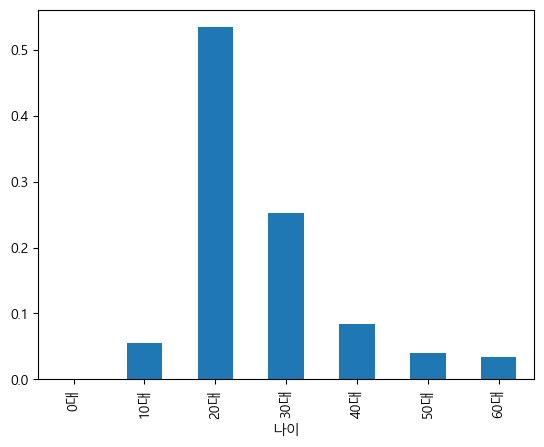

In [37]:
# fig, axes = plt.subplots(1,2, figsize=(12,5))

age_categories =  pd.cut(df["나이"],bins = list(range(0, int(df["나이"].max()) + 10, 10)),labels = [f"{x}대"for x in range(0, int(df["나이"].max()), 10)])
age_categories.value_counts(normalize=True).sort_index().plot(kind="bar")
# sns.displot(df["나이"], bins=range(0, int(df["나이"].max()) + 1, 10)).set(title="나이대 인구수")
# plt.show()

In [50]:
TEST_IMAGE_ROOT = "../test/DCM"
test_pngs = {
    os.path.relpath(os.path.join(root, fname), start=TEST_IMAGE_ROOT)
    for root, _dirs, files in os.walk(TEST_IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

print(len(df), (len(pngs) + len(test_pngs)) // 2)

550 544


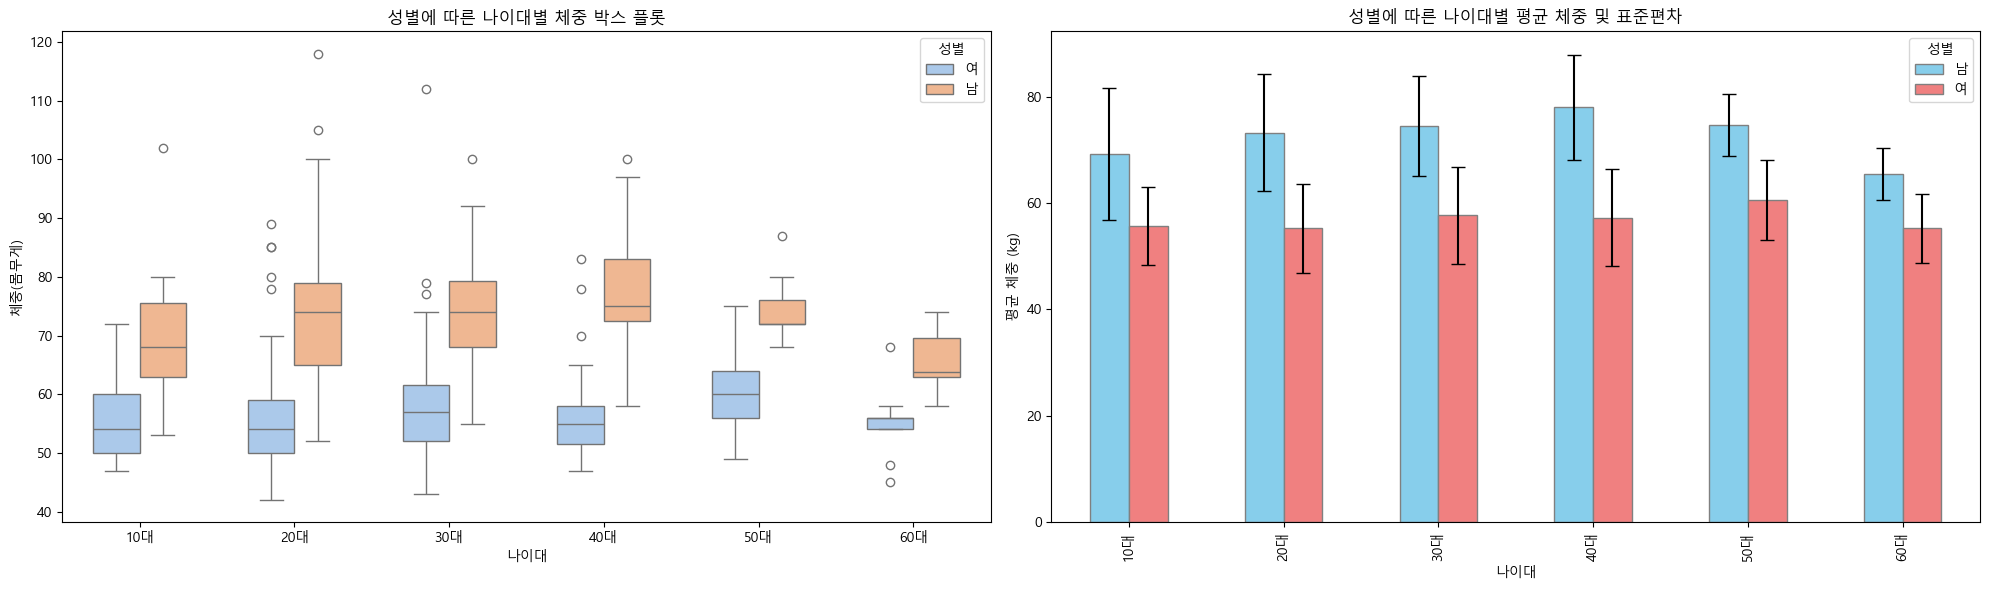

In [39]:
df['나이대'] =  pd.cut(df["나이"],bins = list(range(10, int(df["나이"].max()) + 10, 10)),labels = [f"{x}대"for x in range(10, int(df["나이"].max()), 10)])
height_age = df.groupby(['성별','나이대'], observed=False)['체중(몸무게)'].describe()
# height_age.describe()

# 그래프 시각화
plt.figure(figsize=(20, 6))

# 1. 박스 플롯: 성별에 따른 나이대별 체중 박스 플롯
plt.subplot(1, 2, 1)
sns.boxplot(x='나이대', y='체중(몸무게)', hue='성별', data=df, palette='pastel', width=0.6)
plt.title('성별에 따른 나이대별 체중 박스 플롯')
plt.xlabel('나이대')
plt.ylabel('체중(몸무게)')

# 2. 바 플롯: 성별에 따른 나이대별 평균 체중 및 표준편차
plt.subplot(1, 2, 2)
mean_values = height_age['mean'].unstack('성별')
std_values = height_age['std'].unstack('성별')
mean_values.plot(kind='bar', yerr=std_values, capsize=5, color=['skyblue', 'lightcoral'], edgecolor='gray', ax=plt.gca())
plt.title('성별에 따른 나이대별 평균 체중 및 표준편차')
plt.xlabel('나이대')
plt.ylabel('평균 체중 (kg)')

plt.tight_layout()
plt.show()

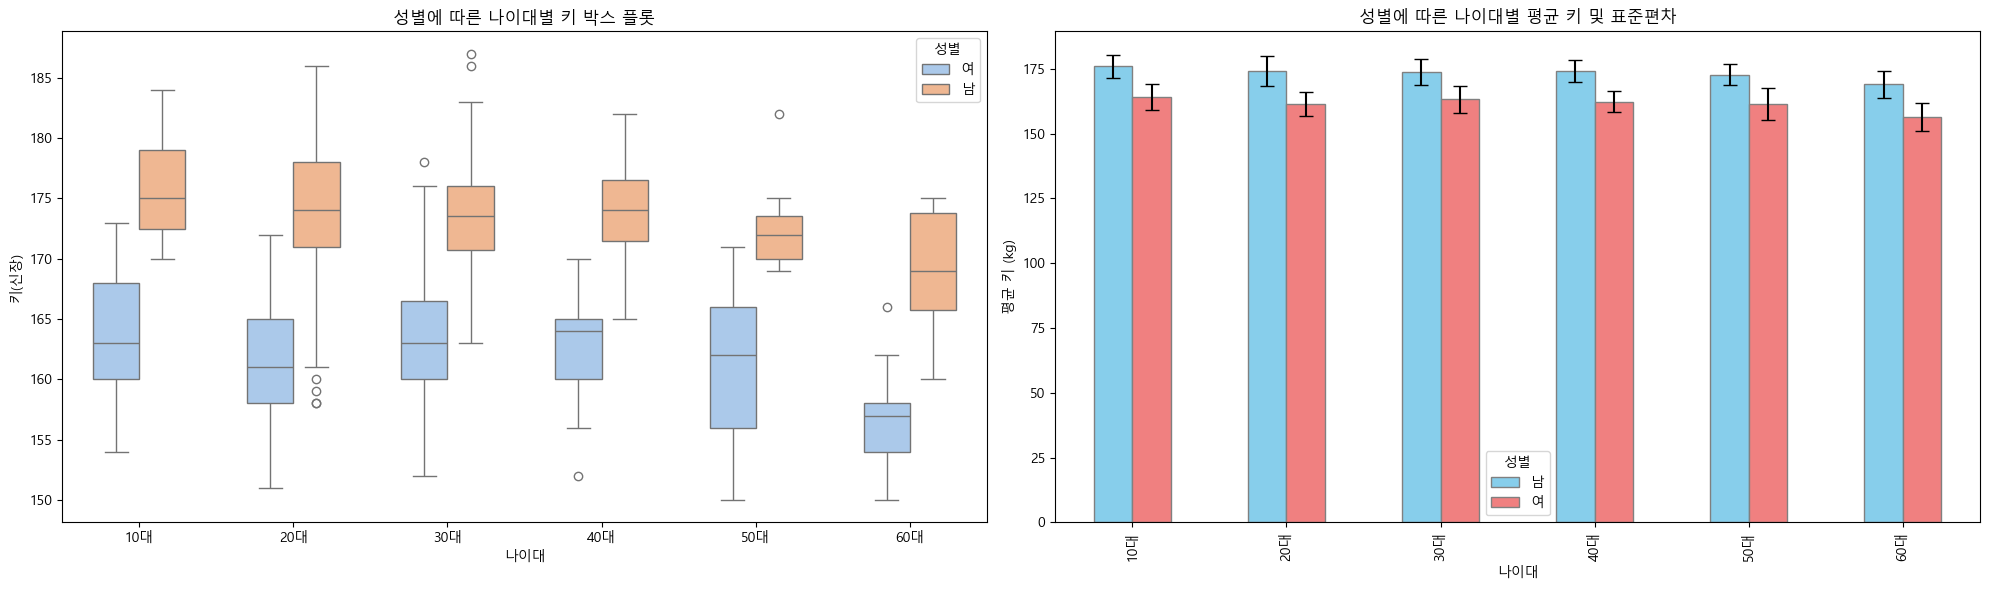

In [56]:
df['나이대'] =  pd.cut(df["나이"],bins = list(range(10, int(df["나이"].max()) + 10, 10)),labels = [f"{x}대"for x in range(10, int(df["나이"].max()), 10)])
height_age = df.groupby(['성별','나이대'], observed=False)['키(신장)'].describe()
# height_age.describe()

# 그래프 시각화
plt.figure(figsize=(20, 6))

# 1. 박스 플롯: 성별에 따른 나이대별 체중 박스 플롯
plt.subplot(1, 2, 1)
sns.boxplot(x='나이대', y='키(신장)', hue='성별', data=df, palette='pastel', width=0.6)
plt.title('성별에 따른 나이대별 키 박스 플롯')
plt.xlabel('나이대')
plt.ylabel('키(신장)')

# 2. 바 플롯: 성별에 따른 나이대별 평균 체중 및 표준편차
plt.subplot(1, 2, 2)
mean_values = height_age['mean'].unstack('성별')
std_values = height_age['std'].unstack('성별')
mean_values.plot(kind='bar', yerr=std_values, capsize=5, color=['skyblue', 'lightcoral'], edgecolor='gray', ax=plt.gca())
plt.title('성별에 따른 나이대별 평균 키 및 표준편차')
plt.xlabel('나이대')
plt.ylabel('평균 키 (kg)')

plt.tight_layout()
plt.show()

In [15]:
notes_non_nan_values = df['Unnamed: 5'][~df['Unnamed: 5'].isna()]
notes_non_nan_indices = df[~df['Unnamed: 5'].isna()].index
print("비고: ",notes_non_nan_values)

notes_non_nan_indices = [int(idx) for idx in notes_non_nan_indices]


비고:  72    네일있음
Name: Unnamed: 5, dtype: object


In [52]:
df[(df['나이대'] == '20대') & (df['성별'] == '여')
   & (df['체중(몸무게)'] <= 60) & (df['체중(몸무게)'] >= 50)]

,ID,나이,성별,체중(몸무게),키(신장),Unnamed: 5,나이대
5,6,28,여,52.0,161.0,NaN,20대
13,14,24,여,56.0,159.0,NaN,20대
21,22,29,여,55.0,153.0,NaN,20대
31,32,28,여,53.0,160.0,NaN,20대
33,34,24,여,59.0,153.0,NaN,20대
...,...,...,...,...,...,...,...
541,542,25,여,50.0,157.0,NaN,20대
543,544,25,여,56.0,163.0,NaN,20대
544,545,24,여,60.0,156.0,NaN,20대
545,546,28,여,50.0,158.0,NaN,20대


In [ ]:
image, label = train_dataset[10]
fig, ax = plt.subplots(len(notes_non_nan_indices)+1, 2, figsize=(12, 12))

# base setting
ax[0,0].set_title("Original")
ax[0,1].set_title("Segmentation")

ax[0,0].imshow(image[0])
ax[0,1].imshow(label2rgb(label))

for idx, (notes_value, notes_idx) in enumerate(zip(notes_non_nan_values, notes_non_nan_indices)):
    image, label = train_dataset[notes_idx*2]
    ax[idx+1, 0].set_title(f"{notes_idx}번 이미지에 {notes_value}")
    ax[idx+1, 1].set_title("Segmentation")
    
    ax[idx+1, 0].imshow(image[0])
    ax[idx+1, 1].imshow(label2rgb(label))

plt.rc('font', family='Malgun Gothic')
plt.show()

In [ ]:

image, label = train_dataset[10]
fig, ax = plt.subplots(len(notes_non_nan_indices)+1, 2, figsize=(12, 12))

# base setting
ax[0,0].set_title("Original")
ax[0,1].set_title("Segmentation")

ax[0,0].imshow(image[0])
ax[0,1].imshow(label2rgb(label))

for idx, (notes_value, notes_idx) in enumerate(zip(notes_non_nan_values, notes_non_nan_indices)):
    image, label = train_dataset[notes_idx*2]
    ax[idx+1, 0].set_title(f"{notes_idx}번 이미지에 {notes_value}")
    ax[idx+1, 1].set_title("Segmentation")
    
    ax[idx+1, 0].imshow(image[0])
    ax[idx+1, 1].imshow(label2rgb(label))

plt.rc('font', family='Malgun Gothic')
plt.show()

# 클래스별 픽셀 차지 비율

In [57]:
total_positive_ratio = 0
total_negative_ratio = 0

for i in tqdm(range(len(train_dataset))):
    image, label = train_dataset[i]  # train_dataset[i]에서 이미지와 라벨을 가져옴

    # Tensor일 경우 numpy 배열로 변환
    if isinstance(label, torch.Tensor):
        label = label.cpu().numpy()
    if isinstance(image, torch.Tensor):
        image = image.cpu().numpy()

    # 전체 픽셀 수 (H * W)
    total_pixels = label.shape[1] * label.shape[2]

    # 모든 클래스에서 Positive Samples(객체가 있는 영역) 마스크 생성
    positive_mask = np.any(label == 1, axis=0)  # (512, 512) 모양의 2D 마스크
    positive_pixel_count = np.sum(positive_mask)

    # Negative Samples(객체가 없는 영역) 계산
    negative_pixel_count = total_pixels - positive_pixel_count

    # Positive/Negative 비율 계산
    positive_ratio = positive_pixel_count / total_pixels
    negative_ratio = negative_pixel_count / total_pixels

    # 누적 계산
    total_positive_ratio += positive_ratio
    total_negative_ratio += negative_ratio

# 평균 비율 계산
avg_positive_ratio = total_positive_ratio / len(train_dataset)
avg_negative_ratio = total_negative_ratio / len(train_dataset)


  0%|          | 0/640 [00:00<?, ?it/s]

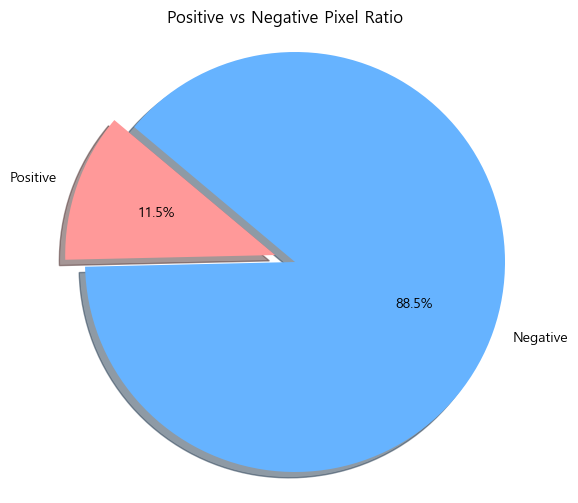

In [59]:
# 파이 그래프 시각화
labels = ['Positive', 'Negative']
sizes = [avg_positive_ratio, avg_negative_ratio]
colors = ['#ff9999','#66b3ff']  # 색상 지정
explode = (0.1, 0)  # 첫 번째 조각만 강조

plt.figure(figsize=(6,6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', shadow=True, startangle=140)
plt.axis('equal')  # 원이 정원형이 되도록
plt.title('Positive vs Negative Pixel Ratio')

# 그래프 표시
plt.show()


- positive samples 보다 negative samples가 많은 것을 볼 수 있음.

In [52]:
def calculate_class_pixel_ratio():
    _, label = train_dataset[0]
    class_ratios = [0] * label.shape[0]
    for idx in tqdm(range(len(train_dataset))):
        _, label = train_dataset[idx]
        # Tensor일 경우 numpy 배열로 변환
        if isinstance(label, torch.Tensor):
            label = label.cpu().numpy()

        # 전체 이미지의 픽셀 수 (H * W)
        total_pixels = label.shape[1] * label.shape[2]

        # 각 클래스의 픽셀 수 계산
        for i, class_label in enumerate(label):
            # 현재 클래스의 픽셀 수 계산
            class_pixel_count = np.sum(class_label == 1)
            
            # 클래스 픽셀 비율 계산
            class_ratio = class_pixel_count / total_pixels
            class_ratios[i] += class_ratio
    
    return [class_ratio/len(train_dataset) for class_ratio in class_ratios]

  0%|          | 0/640 [00:00<?, ?it/s]

c:\Users\clear\miniconda3\envs\deep_learning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 48324 (\N{HANGUL SYLLABLE BYEOL}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\clear\miniconda3\envs\deep_learning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\clear\miniconda3\envs\deep_learning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\clear\miniconda3\envs\deep_learning\lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


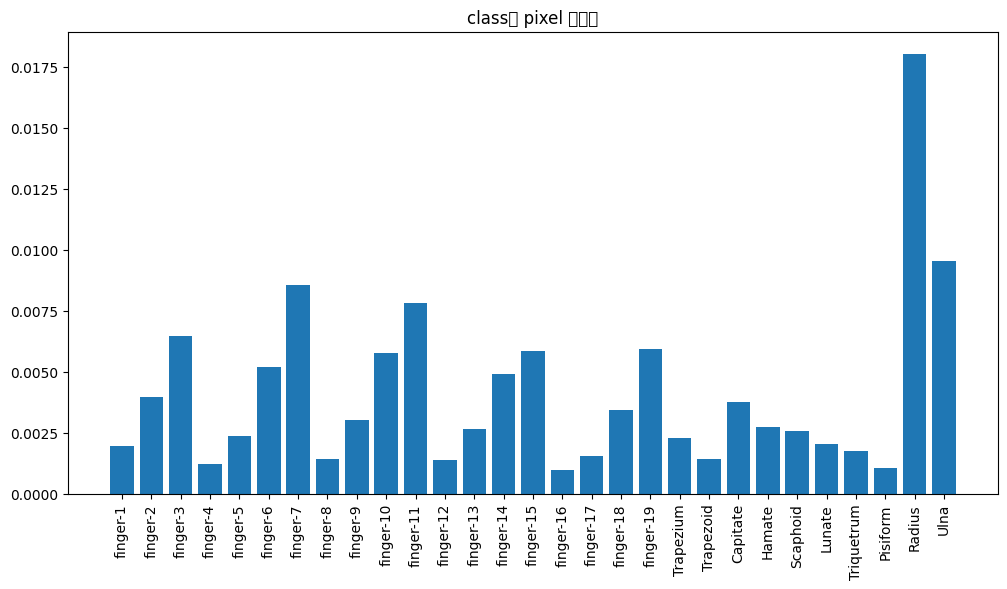

In [53]:
class_ratio = calculate_class_pixel_ratio()
plt.figure(figsize=(12,6))
plt.bar(CLASSES, class_ratio)
plt.xticks(rotation=90)
plt.title("class별 pixel 차이수")
plt.show()

In [ ]:
df[df['성별']=='여']

In [4]:
df = pd.read_excel("../meta_data.xlsx", engine='openpyxl')
df.describe()
# data cleansing

# _x0008_를 빈 문자열로 교체
df['성별'] = df['성별'].str.replace('_x0008_', '', regex=False)
df['성별'] = df['성별'].str.replace(' ', '', regex=False)

In [ ]:
def change_form(image_name, label_name):
    image_path = os.path.join(IMAGE_ROOT, image_name)

    image = cv2.imread(image_path)
    image = image / 255.

    label_path = os.path.join(LABEL_ROOT, label_name)

    # (H, W, NC) 모양의 label을 생성합니다.
    label_shape = tuple(image.shape[:2]) + (len(CLASSES), )
    label = np.zeros(label_shape, dtype=np.uint8)

    # label 파일을 읽습니다.
    with open(label_path, "r") as f:
        annotations = json.load(f)
    annotations = annotations["annotations"]

    # 클래스 별로 처리합니다.
    for ann in annotations:
        c = ann["label"]
        class_ind = CLASS2IND[c]
        points = np.array(ann["points"])
        
        # polygon 포맷을 dense한 mask 포맷으로 바꿉니다.
        class_label = np.zeros(image.shape[:2], dtype=np.uint8)
        cv2.fillPoly(class_label, [points], 1)
        label[..., class_ind] = class_label


    # to tenser will be done later
    image = image.transpose(2, 0, 1)    # channel first 포맷으로 변경합니다.
    label = label.transpose(2, 0, 1)

    image = torch.from_numpy(image).float()
    label = torch.from_numpy(label).float()
        
    return image, label

In [ ]:
import os
import cv2
import matplotlib.pyplot as plt

# 조건: 키 범위 (예: 160 ~ 170), 몸무게 범위 (예: 50 ~ 60)
min_height = 160
max_height = 170
min_weight = 50
max_weight = 60

# '여' 성별이면서 키와 몸무게가 특정 범위 내에 있는 사람들
filtered_df = df[(df['성별'] == '남') &
                 (df['키(신장)'] >= min_height) &
                 (df['키(신장)'] <= max_height) &
                 (df['체중(몸무게)'] >= min_weight) &
                 (df['체중(몸무게)'] <= max_weight)]

# 조건에 맞는 ID 리스트
filtered_ids = filtered_df['ID'].reset_index(drop=True)


# jsons = {
#     os.path.relpath(os.path.join(root, fname), start=LABEL_ROOT)
#     for root, _dirs, files in os.walk(LABEL_ROOT)
#     for fname in files
#     if os.path.splitext(fname)[1].lower() == ".json"
# }

# 조건에 맞는 이미지 로드
for woman_id_value in filtered_ids[:20]:
    id_path = os.path.join(IMAGE_ROOT, f'ID{woman_id_value:03d}')
    json_path = os.path.join(LABEL_ROOT, f'ID{woman_id_value:03d}') 
    # 해당 ID에 대한 폴더가 존재하는지 확인
    if not os.path.exists(id_path):
        print(f"폴더 {id_path}가 존재하지 않습니다. 건너뜁니다.")
        continue  # 폴더가 없으면 건너뜀
    
    # 해당 ID의 모든 이미지 파일 중 2개만 로드
    image_files = sorted(os.listdir(id_path))[:2]  # 상위 2개의 이미지 파일만 가져옴
    json_files = sorted(os.listdir(json_path))[:2]
    plt.figure(figsize=(12, 5))
    for idx, (ifname,lfname) in enumerate(zip(image_files,json_files)):
        image_path = os.path.join(id_path, ifname)
        
        # 이미지 로드
        img = cv2.imread(image_path)
        
        # 이미지 로드가 성공했으면 출력
        if img is not None:
            plt.subplot(1,2,idx+1)
            plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  # OpenCV는 BGR 순서이므로 RGB로 변환
            plt.title(f"ID: {woman_id_value}, File: {ifname}")
            plt.axis('off')  # 축 제거
        else:
            print(f"Image {ifname} could not be loaded.")
    plt.show()

In [ ]:
# 성별별 class 별 pixel 차이수

def calculate_class_pixel_ratio():
    _, label = train_dataset[0]
    class_ratios = [0] * label.shape[0]
    for idx in tqdm(range(len(train_dataset))):
        _, label = train_dataset[idx]
        # Tensor일 경우 numpy 배열로 변환
        if isinstance(label, torch.Tensor):
            label = label.cpu().numpy()

        # 전체 이미지의 픽셀 수 (H * W)
        total_pixels = label.shape[1] * label.shape[2]

        # 각 클래스의 픽셀 수 계산
        for i, class_label in enumerate(label):
            # 현재 클래스의 픽셀 수 계산
            class_pixel_count = np.sum(class_label == 1)
            
            # 클래스 픽셀 비율 계산
            class_ratio = class_pixel_count / total_pixels
            class_ratios[i] += class_ratio
    
    return [class_ratio/len(train_dataset) for class_ratio in class_ratios]

# Setup Dataloader

In [ ]:
train_loader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=8,
    drop_last=True,
)

# 주의: validation data는 이미지 크기가 크기 때문에 `num_wokers`는 커지면 메모리 에러가 발생할 수 있습니다.
valid_loader = DataLoader(
    dataset=valid_dataset, 
    batch_size=8,
    shuffle=False,
    num_workers=0,
    drop_last=False
)

# Inference

In [ ]:
model = torch.load(os.path.join(SAVED_DIR, "fcn_resnet50_best_model.pt"))

In [ ]:
# 테스트 데이터 경로를 입력하세요

IMAGE_ROOT = "test/DCM"

In [ ]:
pngs = {
    os.path.relpath(os.path.join(root, fname), start=IMAGE_ROOT)
    for root, _dirs, files in os.walk(IMAGE_ROOT)
    for fname in files
    if os.path.splitext(fname)[1].lower() == ".png"
}

In [ ]:
# mask map으로 나오는 인퍼런스 결과를 RLE로 인코딩 합니다.

def encode_mask_to_rle(mask):
    '''
    mask: numpy array binary mask 
    1 - mask 
    0 - background
    Returns encoded run length 
    '''
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
# RLE로 인코딩된 결과를 mask map으로 복원합니다.

def decode_rle_to_mask(rle, height, width):
    s = rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(height * width, dtype=np.uint8)
    
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    
    return img.reshape(height, width)

In [ ]:
class XRayInferenceDataset(Dataset):
    def __init__(self, transforms=None):
        _filenames = pngs
        _filenames = np.array(sorted(_filenames))
        
        self.filenames = _filenames
        self.transforms = transforms
    
    def __len__(self):
        return len(self.filenames)
    
    def __getitem__(self, item):
        image_name = self.filenames[item]
        image_path = os.path.join(IMAGE_ROOT, image_name)
        
        image = cv2.imread(image_path)
        image = image / 255.
        
        if self.transforms is not None:
            inputs = {"image": image}
            result = self.transforms(**inputs)
            image = result["image"]

        # to tenser will be done later
        image = image.transpose(2, 0, 1)  
        
        image = torch.from_numpy(image).float()
            
        return image, image_name

In [ ]:
def test(model, data_loader, thr=0.5):
    model = model.cuda()
    model.eval()

    rles = []
    filename_and_class = []
    with torch.no_grad():
        n_class = len(CLASSES)

        for step, (images, image_names) in tqdm(enumerate(data_loader), total=len(data_loader)):
            images = images.cuda()    
            outputs = model(images)['out']
            
            outputs = F.interpolate(outputs, size=(2048, 2048), mode="bilinear")
            outputs = torch.sigmoid(outputs)
            outputs = (outputs > thr).detach().cpu().numpy()
            
            for output, image_name in zip(outputs, image_names):
                for c, segm in enumerate(output):
                    rle = encode_mask_to_rle(segm)
                    rles.append(rle)
                    filename_and_class.append(f"{IND2CLASS[c]}_{image_name}")
                    
    return rles, filename_and_class

In [ ]:
tf = A.Resize(512, 512)

In [ ]:
test_dataset = XRayInferenceDataset(transforms=tf)

In [ ]:
test_loader = DataLoader(
    dataset=test_dataset, 
    batch_size=2,
    shuffle=False,
    num_workers=2,
    drop_last=False
)

In [ ]:
rles, filename_and_class = test(model, test_loader)

# Result Visualization

In [ ]:
filename_and_class[0]

In [ ]:
image = cv2.imread(os.path.join(IMAGE_ROOT, filename_and_class[0].split("_")[1]))
preds = []
for rle in rles[:len(CLASSES)]:
    pred = decode_rle_to_mask(rle, height=2048, width=2048)
    preds.append(pred)

preds = np.stack(preds, 0)

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(24, 12))
ax[0].imshow(image)    # remove channel dimension
ax[1].imshow(label2rgb(preds))

plt.show()